## Loading dependencies and data

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
import statsmodels.api as sm
import scipy.stats as stats

# Load the dataset
file = '../new-data/everything_merged_dataset_no_NULL_violent&sexual.csv'
data = pd.read_csv(file)

## Visualize data
Some visualization of data before analyses

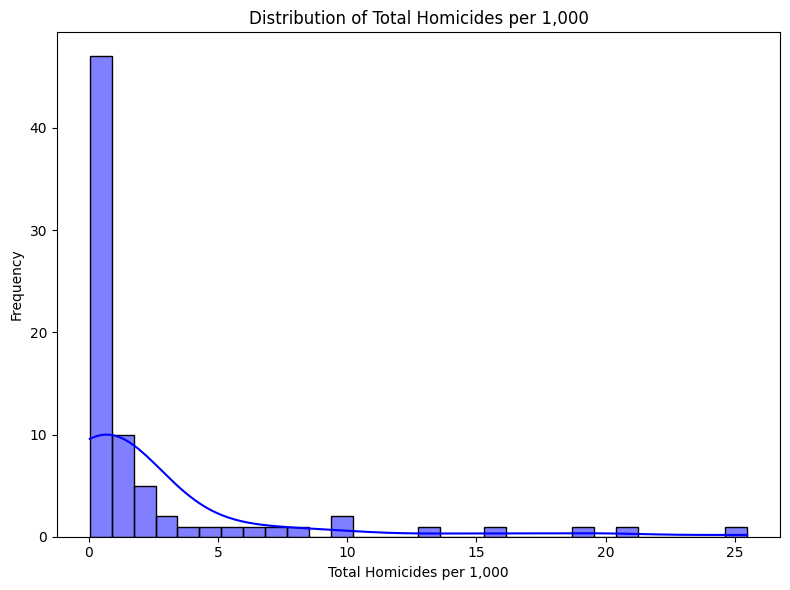

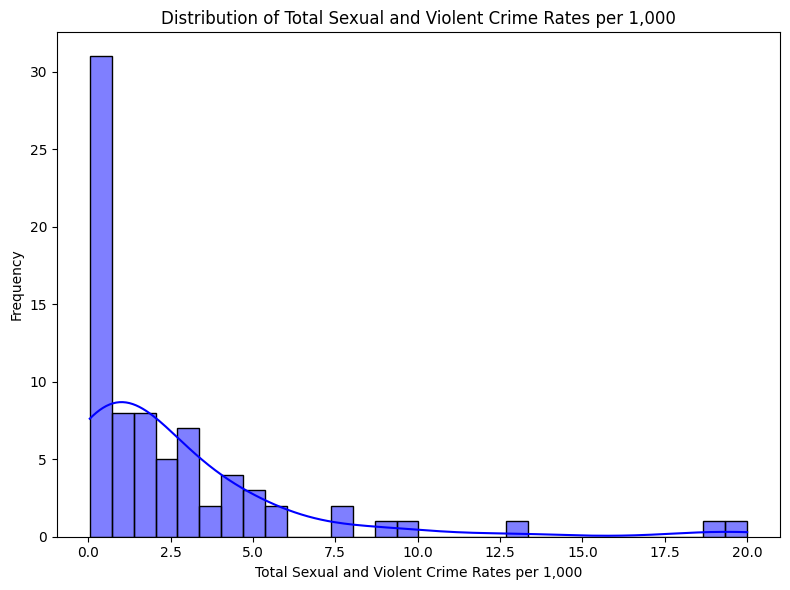

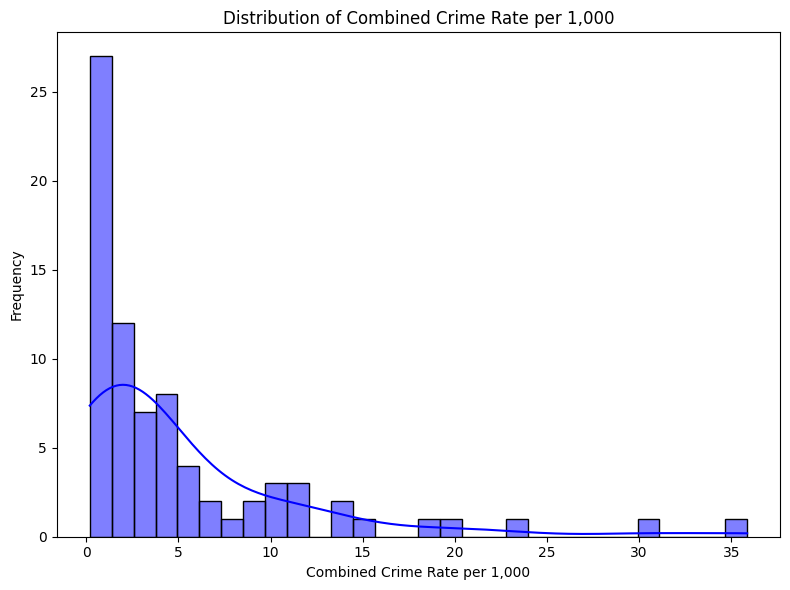

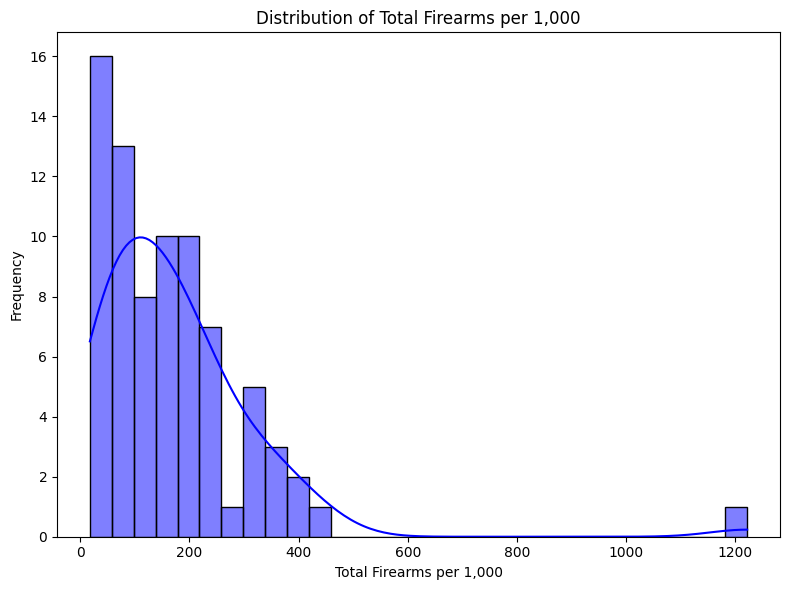

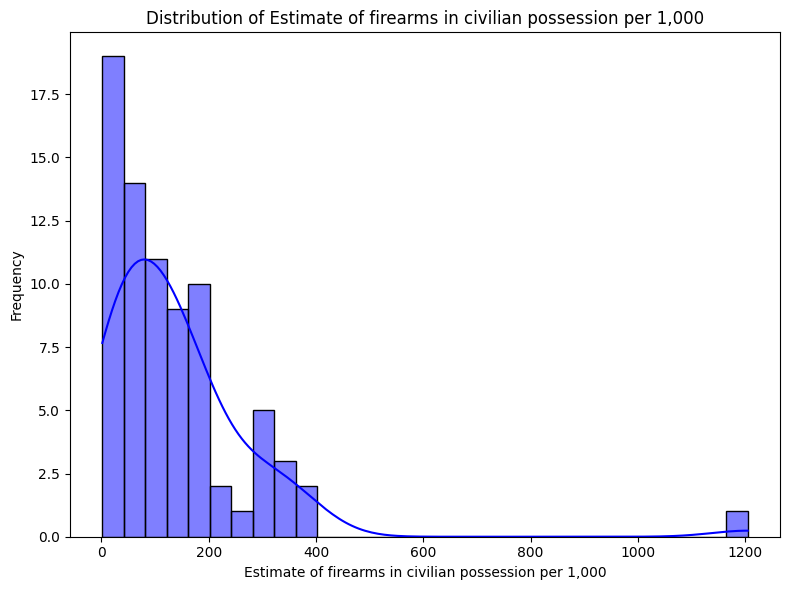

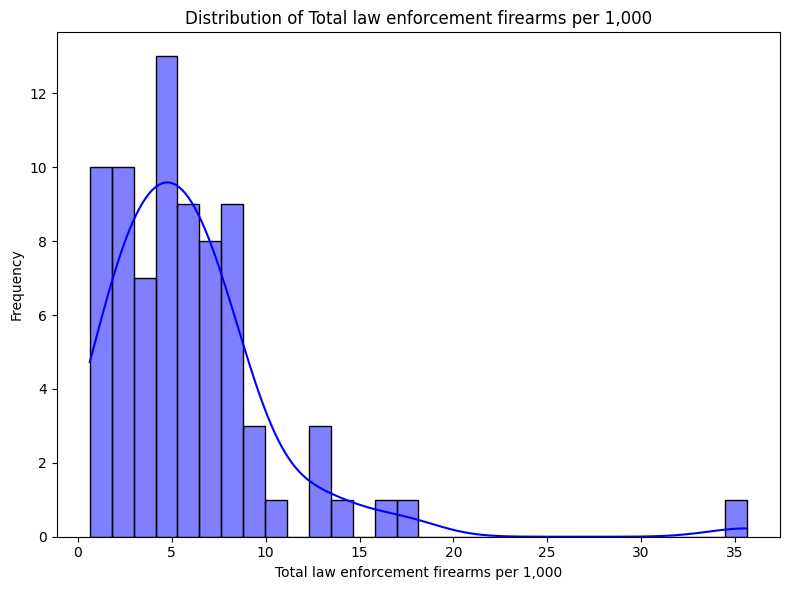

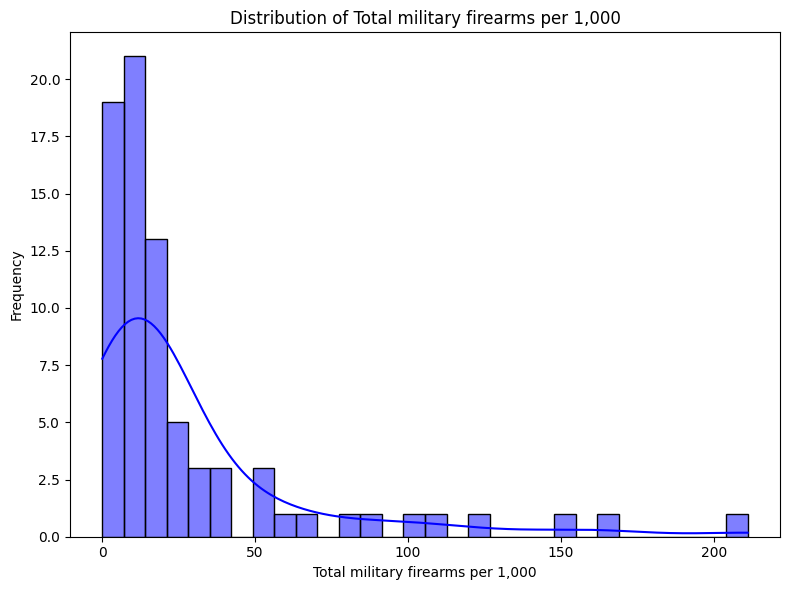

In [77]:
# We use the columns with the per 1000 data
columns_per_1000 = [
    "Total Homicides per 1,000",
    "Total Sexual and Violent Crime Rates per 1,000",
    "Combined Crime Rate per 1,000",
    "Total Firearms per 1,000",
    "Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000"
]

# And now we create histograms to visualize distribution of data
for column in columns_per_1000:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=30, kde=True, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

<Figure size 2500x2000 with 0 Axes>

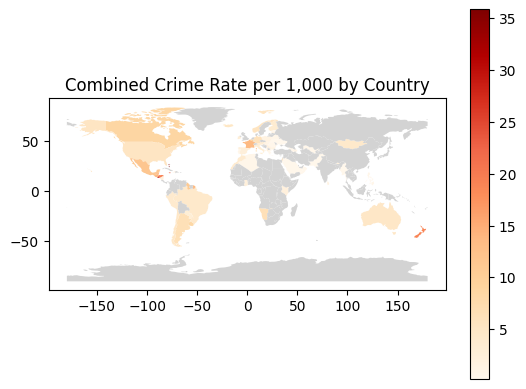

<Figure size 2500x2000 with 0 Axes>

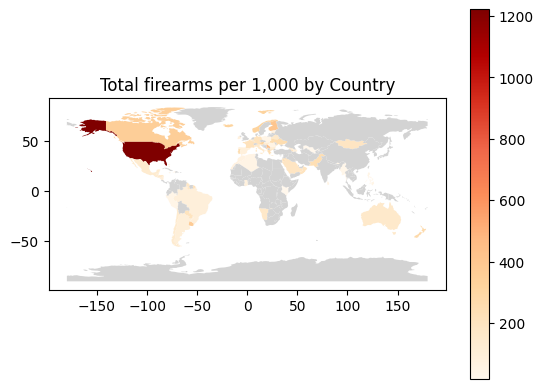

In [78]:
# Create world maps
file_path = "../new-data/geo/ne_110m_admin_0_countries.shx" # world map data
world = gpd.read_file(file_path)
world = world.rename(columns={"NAME": "Country"})

# Merge data with world map
map_data = world.merge(data, on="Country", how="left")

# Plot Combined Crime Rate per 1,000
plt.figure(figsize=(25, 20))
map_data.plot(
    column="Combined Crime Rate per 1,000",
    cmap="OrRd",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Combined Crime Rate per 1,000 by Country")
plt.show()

# Plot Total firearms per 1,000 by Country
plt.figure(figsize=(25, 20))
map_data.plot(
    column="Total Firearms per 1,000",
    cmap="OrRd",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Total firearms per 1,000 by Country")
plt.show()

## Analyses of RQs
This is a start I guess

1. What is the general relationship between total sum of weapons for each type of crime seperated and also all types of crime combined  
2. group countries with similar gun stats together and check how their distributions compare  
3. check if GDP could be a confounding variable (AKA, check relationship between GDP and crime stats)  
4. Check if the presence of weapons in civilian hands changes stuff (check whether that could be a confounding variable too)  

As for question 2:
- 3 that contain the % of type of firearm possesion
- one that contains the distribution
- column "firearm group" which is a way to group countries together that have a similar distribution, basically each country gets assigned a group number

I printed the data so you guys can see  
It's not done yet but we can work with it maybe

### **First off - grouping countries**:
**I suggest that we group countries in 4 categories based on the total number of weapons per 1000 ppl (Low, Medium-Low, Medium-High, High). This way, we can have roughly equally-sized groups and will have variability withing the groups in terms of proportion of weapon ownership (some will have bigger proportion of civilian, military, or law enforcement), where the dominant ownership type will be recorded in a column. The current method for creating the groups is more precise in terms of having countries with similar total weapons in the same group, but we also have many more groups, some of them having only 2 members, which will make analysis more difficult.**

In [79]:
data["Total Firearms Group"] = pd.qcut(
    data["Total Firearms per 1,000"], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"]
)

# I won't be using them it looks like because it causes some issues in the regression
data["Civilian Proportion"] = (
    data["Estimate of firearms in civilian possession per 1,000"] / data["Total Firearms per 1,000"]
) * 100
data["Military Proportion"] = (
    data["Total military firearms per 1,000"] / data["Total Firearms per 1,000"]
) * 100
data["Law Enforcement Proportion"] = (
    data["Total law enforcement firearms per 1,000"] / data["Total Firearms per 1,000"]
) * 100

data.head(10)

,ISO,Country,Continent,Subregion,Year,Population,Estimate of firearms in civilian possession,Total law enforcement firearms,Total military firearms,"Estimate of firearms in civilian possession per 1,000",...,"Total Homicides per 1,000","Total Sexual and Violent Crime Rates per 1,000",Country GDP,"Country GDP per 1,000","Combined Crime Rate per 1,000","Total Firearms per 1,000",Total Firearms Group,Civilian Proportion,Military Proportion,Law Enforcement Proportion
0,ALB,Albania,Europe,Southern Europe,2018,2911000.0,350000,19000,21750.0,120.233597,...,2.146341,0.468911,1.537951e+10,5.283239e+06,2.615252,134.232223,Medium-Low,89.571337,5.566219,4.862444
1,DZA,Algeria,Africa,Northern Africa,2018,41064000.0,877000,363000,637720.0,21.356906,...,0.239991,0.487239,1.945540e+11,4.737824e+06,0.727231,45.726671,Low,46.705579,33.962465,19.331956
2,ATG,Antigua and Barbuda,Americas,Latin America and the Caribbean,2018,94000.0,5000,800,438.0,53.191489,...,5.680851,4.851064,1.661530e+09,1.767585e+07,10.531915,66.361702,Low,80.153895,7.021481,12.824623
3,ARG,Argentina,Americas,Latin America and the Caribbean,2018,44272000.0,3256000,391000,679770.0,73.545356,...,2.708032,3.820473,5.248200e+11,1.185445e+07,6.528506,97.731523,Medium-Low,75.252440,15.710796,9.036764
4,ARM,Armenia,Asia,Western Asia,2018,3032000.0,186000,18000,509240.0,61.345646,...,0.407982,0.137203,1.245794e+10,4.108819e+06,0.545185,235.237467,High,26.078178,71.398127,2.523695
5,AUS,Australia,Oceania,Australia and New Zealand,2018,24642000.0,3573000,69000,214520.0,144.996348,...,0.408733,4.470376,1.427810e+12,5.794213e+07,4.879109,156.501907,Medium-High,92.648294,5.562528,1.789178
6,AUT,Austria,Europe,Western Europe,2018,8592000.0,2577000,37900,240880.0,299.930168,...,0.548650,2.890480,4.525820e+11,5.267481e+07,3.439129,332.376629,High,90.238044,8.434823,1.327133
7,AZE,Azerbaijan,Asia,Western Asia,2018,9974000.0,362000,18000,537920.0,36.294365,...,0.930018,0.113094,4.711247e+10,4.723528e+06,1.043112,92.031281,Medium-Low,39.436988,58.602057,1.960955
8,BHS,Bahamas,Americas,Latin America and the Caribbean,2018,397000.0,74000,5000,2470.0,186.397985,...,15.863980,20.000000,1.261580e+10,3.177783e+07,35.863980,205.214106,Medium-High,90.830981,3.031791,6.137228
9,BRB,Barbados,Americas,Latin America and the Caribbean,2018,286000.0,10000,2000,1675.0,34.965035,...,6.234266,4.461538,5.629916e+09,1.968502e+07,10.695804,47.814685,Low,73.126143,12.248629,14.625229


**Visualize the relationships between firearm-related variables and different crime types using scatterplots with fitted regression lines.** This tests whether the relationship between crime and weapons is non-linear. From the plots, some relationships seem to be slightly non-linear, but the current model is only linear, even though it seems to capture significant effects good enough. We can mention in the limitations and future improvements to better capture the relationships

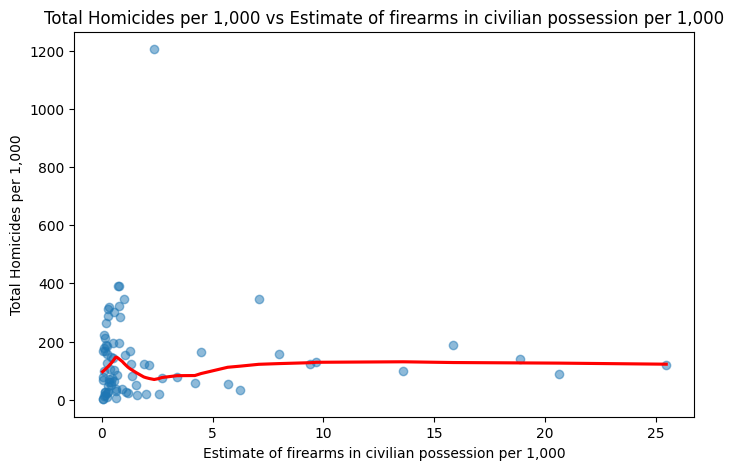

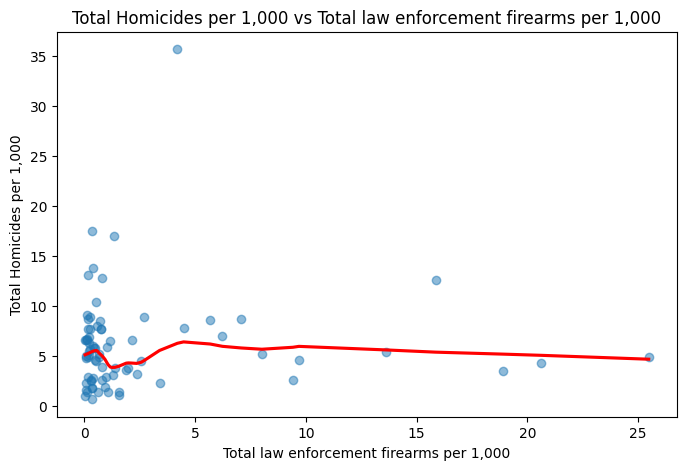

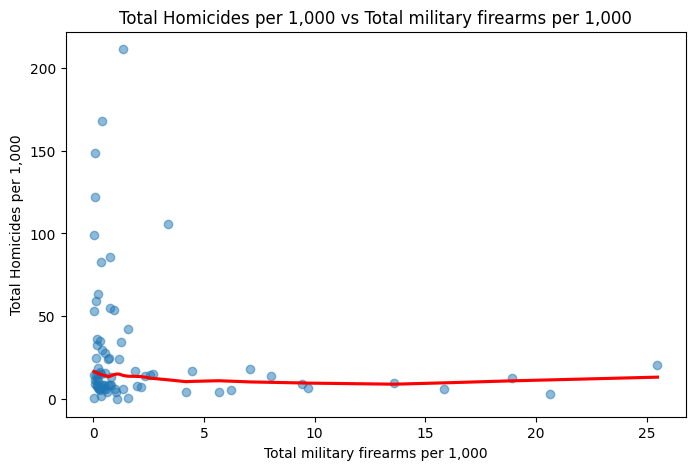

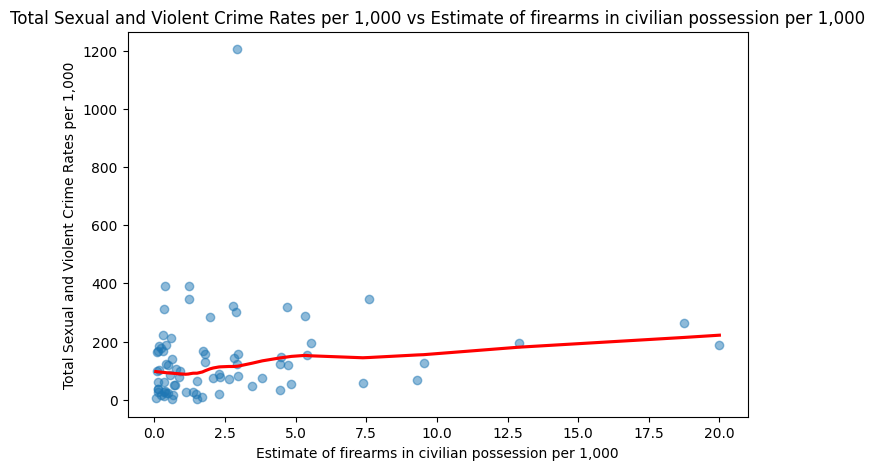

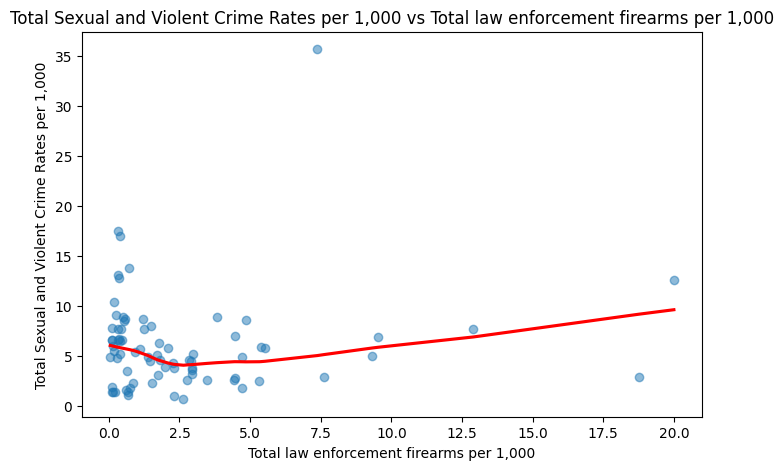

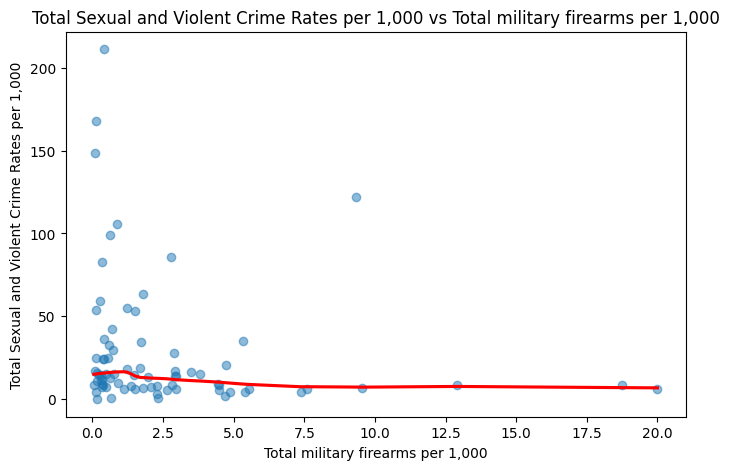

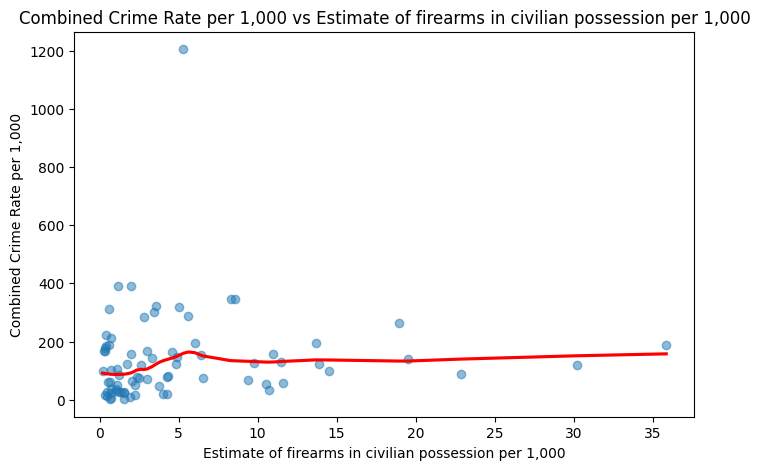

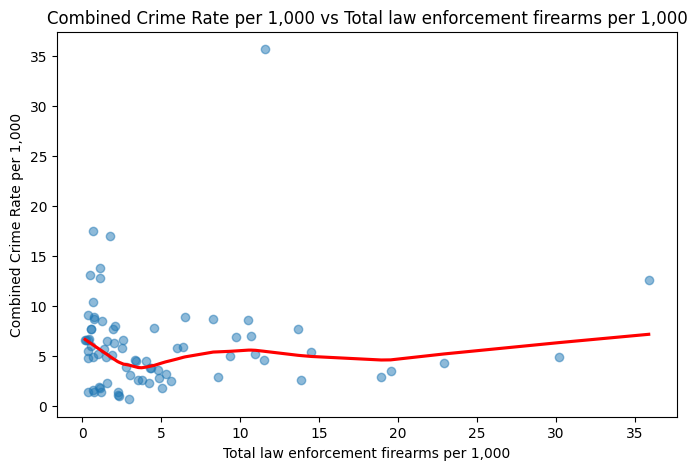

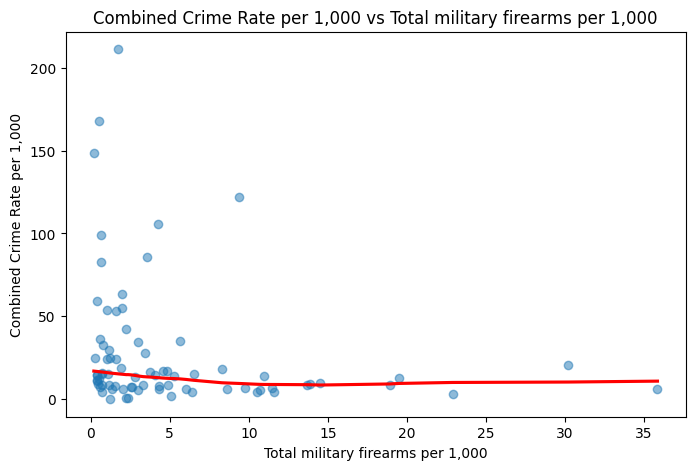

In [80]:
# List of firearm-related variables
firearm_columns = [
    "Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000"
]

# Crime variables
crime_types = [
    "Total Homicides per 1,000",
    "Total Sexual and Violent Crime Rates per 1,000",
    "Combined Crime Rate per 1,000"
]

for crime in crime_types:
    for firearm in firearm_columns:
        plt.figure(figsize=(8, 5))
        sns.regplot(x=data[crime], y=data[firearm], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, lowess=True)
        plt.title(f"{crime} vs {firearm}")
        plt.xlabel(f"{firearm}")
        plt.ylabel(f"{crime}")
        plt.show()

Plot to get an idea for each group how the weapons are roughly distributed

/var/folders/07/1h78q6dd1jv28c8bsv9ztx140000gn/T/ipykernel_93317/4263442305.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime_means_within_group = data.groupby("Total Firearms Group")[


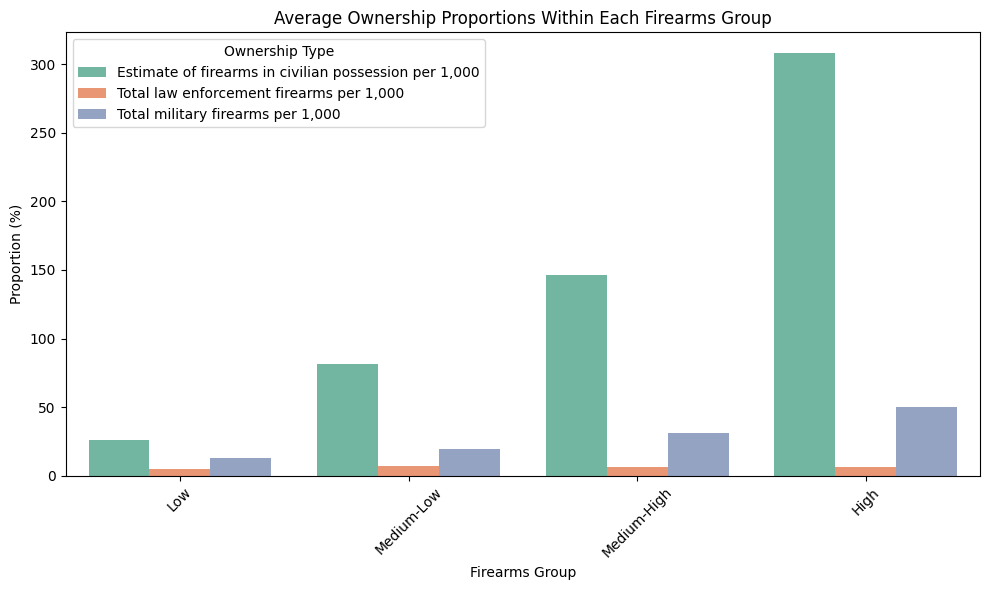

In [81]:
# Compute mean crime rates by firearm group & ownership proportions
crime_means_within_group = data.groupby("Total Firearms Group")[
    ["Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000",
     "Total Homicides per 1,000", 
     "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
].mean().reset_index()

# Plot bar chart for ownership proportions
plt.figure(figsize=(10, 6))
ownership_melted = crime_means_within_group.melt(id_vars="Total Firearms Group", value_vars=["Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000"])
sns.barplot(data=ownership_melted, x="Total Firearms Group", y="value", hue="variable", palette="Set2")

plt.title("Average Ownership Proportions Within Each Firearms Group")
plt.xlabel("Firearms Group")
plt.ylabel("Proportion (%)")
plt.legend(title="Ownership Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Takeaways:**
- In countries with high total firearm ownership, most firearms are civilian-owned.
- In low total firearm countries, the share of military firearms is higher.
- Law enforcement firearms are consistently the least significant contributor.

# **Analysis for Question 1. What is the general relationship between the presence of firearms per country (total N firearms per 1000 citizens) and the amount of homocides, violent and sexual crimes?**
### Is there a statistically significant relationship between the total number of weapons per 1000 ppl and the types of crime (investigate for each crime separately and in total)

Correlations between weapons and crime types:
{'Total Homicides per 1,000': -0.037330999825714604, 'Total Sexual and Violent Crime Rates per 1,000': 0.12020625637442964, 'Combined Crime Rate per 1,000': 0.038990344818663335}


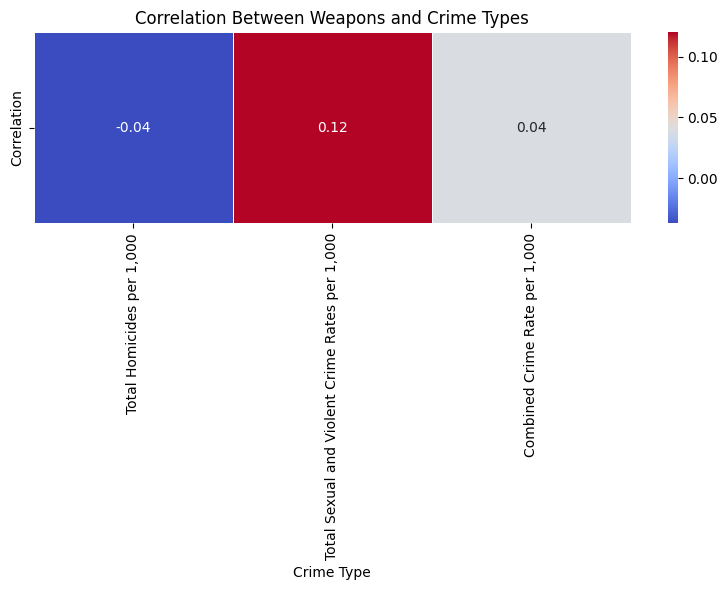

In [82]:
# General Relationship Between Weapons and Crime Types
crime_columns = ["Total Homicides per 1,000", "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
weapon_column = "Total Firearms per 1,000"

# Correlations between weapons and crime types
correlations = {}
for crime in crime_columns:
    correlation, _ = pearsonr(data[weapon_column], data[crime])
    correlations[crime] = correlation

print("Correlations between weapons and crime types:")
print(correlations)

# Create heatmap
correlation_data = pd.DataFrame(list(correlations.items()), columns=["Crime Type", "Correlation"])
plt.figure(figsize=(8, 6))  
sns.heatmap(
    correlation_data.set_index("Crime Type").T,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Correlation Between Weapons and Crime Types")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can add such scatterplots to see the relationship between total weapons vs each crime type for the countries in different groups. I'll print one just to see how it goes, if we decide to use them, uncomment the code for the rest.

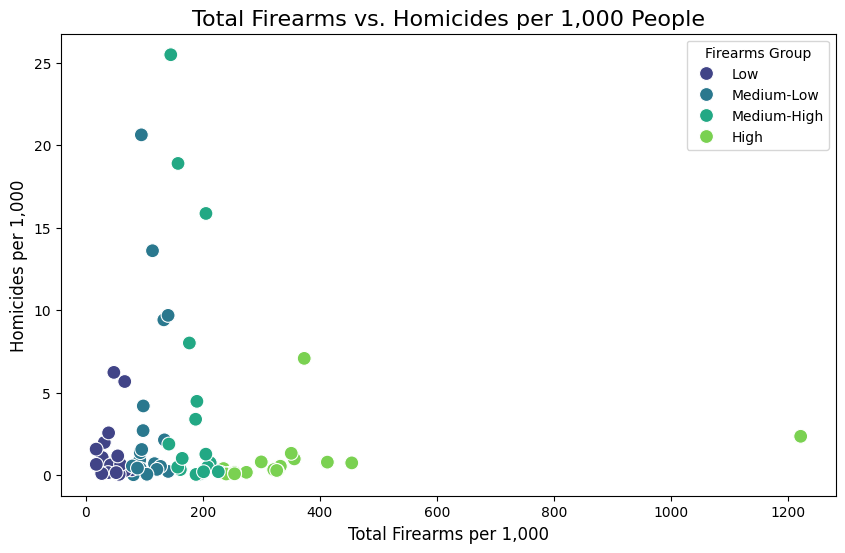

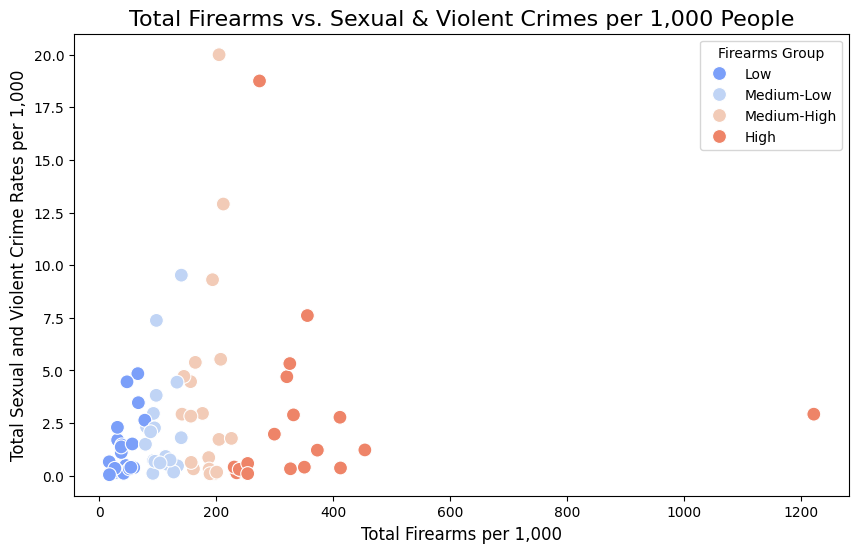

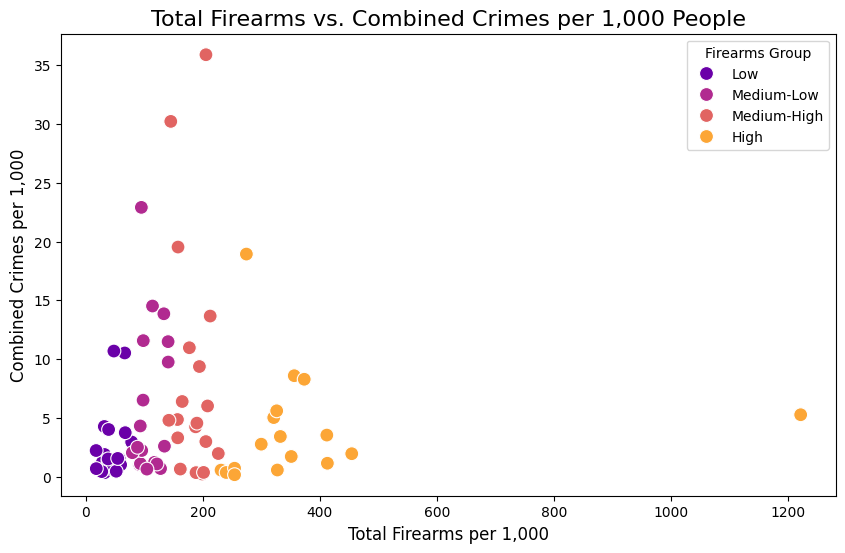

In [83]:
# Scatterplot: Total firearms vs. Homicides
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Total Firearms per 1,000", 
    y="Total Homicides per 1,000", 
    data=data, 
    hue="Total Firearms Group", 
    palette="viridis", 
    s=100
)
plt.title("Total Firearms vs. Homicides per 1,000 People", fontsize=16)
plt.xlabel("Total Firearms per 1,000", fontsize=12)
plt.ylabel("Homicides per 1,000", fontsize=12)
plt.legend(title="Firearms Group")
plt.show()

# Repeat for Violent Crimes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Total Firearms per 1,000", 
    y="Total Sexual and Violent Crime Rates per 1,000", 
    data=data, 
    hue="Total Firearms Group", 
    palette="coolwarm", 
    s=100
)
plt.title("Total Firearms vs. Sexual & Violent Crimes per 1,000 People", fontsize=16)
plt.xlabel("Total Firearms per 1,000", fontsize=12)
plt.ylabel("Total Sexual and Violent Crime Rates per 1,000", fontsize=12)
plt.legend(title="Firearms Group")
plt.show()

# Repeat for Total Crimes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Total Firearms per 1,000", 
    y="Combined Crime Rate per 1,000", 
    data=data, 
    hue="Total Firearms Group", 
    palette="plasma", 
    s=100
)
plt.title("Total Firearms vs. Combined Crimes per 1,000 People", fontsize=16)
plt.xlabel("Total Firearms per 1,000", fontsize=12)
plt.ylabel("Combined Crimes per 1,000", fontsize=12)
plt.legend(title="Firearms Group")
plt.show()

Regression analysis for total number of weapons vs different crime types. GDP is included too as a confounding variable.

The analysis uses a Negative Binomial regression, which is appropriate for count-based crime data that typically exhibit overdispersion (variance > mean). The model includes the main effect of total firearms to examine whether higher firearm ownership increases or decreases crime rates. For combined crime rates, a quadratic term is included to capture potential non-linear relationships, where the effect of firearms on crime may change as firearm levels increase. Additionally, an interaction term between firearms and GDP tests whether the relationship between firearm ownership and crime varies depending on a country’s economic conditions.

In [84]:
# Define crimes and results storage
crime_types = [
    "Total Homicides per 1,000", 
    "Total Sexual and Violent Crime Rates per 1,000", 
    "Combined Crime Rate per 1,000"
]
nb_results_final = {}

# Create interaction term and quadratic term (if applicable)
data["Total_Firearms_Squared"] = data["Total Firearms per 1,000"]**2
# Interaction term for exploring varying relationships based on economic conditions
data["Firearms_GDP_Interaction"] = data["Total Firearms per 1,000"] * data["Country GDP per 1,000"]

for crime in crime_types:
    if crime == "Combined Crime Rate per 1,000":
        X = data[[
            "Total Firearms per 1,000", 
            "Total_Firearms_Squared", 
            "Country GDP per 1,000", 
            "Firearms_GDP_Interaction"
        ]]
    else:
        X = data[[
            "Total Firearms per 1,000", 
            "Country GDP per 1,000", 
            "Firearms_GDP_Interaction"
        ]]
    
    X = sm.add_constant(X) 
    y = data[crime] 

    try:
        # Fit Negative Binomial regression
        model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
        nb_results_final[crime] = model.summary()
    except Exception as e:
        print(f"Skipping {crime} due to error: {e}")

for crime, result in nb_results_final.items():
    print(f"\nNegative Binomial Regression Results for {crime}:\n")
    print(result)


Negative Binomial Regression Results for Total Homicides per 1,000:

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   77
Model:                                   GLM   Df Residuals:                       73
Model Family:               NegativeBinomial   Df Model:                            3
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -154.49
Date:                       Thu, 30 Jan 2025   Deviance:                       96.589
Time:                               19:10:00   Pearson chi2:                     169.
No. Iterations:                           12   Pseudo R-squ. (CS):             0.1777
Covariance Type:                   nonrobust                                         
                               coef    std err          z      P>|z|  

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Summary of the **negative binomial regression results** for **the relationship between the total number of firearms and various crime types**:

### **Summary Table**

| **Dependent Variable**                                  | **Significant Predictors**                | **Direction of Effect**                       | **Key Findings/Interpretation**                                                                                         |
|--------------------------------------------------------|--------------------------------------------|-----------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| **Total Homicides per 1,000**                          | - **Country GDP per 1,000** (**p = 0.001**) | Negative effect                              | Higher GDP per 1,000 people is associated with **lower homicide rates**, but **total firearms** have **no significant effect**. |
| **Total Sexual and Violent Crime Rates per 1,000**     | - **Country GDP per 1,000** (**p = 0.001**) | Positive effect                              | Higher GDP per 1,000 is associated with **higher rates of sexual and violent crimes**. No significant relationship with firearms. |
| **Combined Crime Rate per 1,000**                      | - **Total_Firearms_Squared** (**p = 0.050**) | Non-linear relationship (U-shaped)**          | The quadratic term suggests a **non-linear relationship**: at very low or very high firearm levels, combined crime rates can be affected. Interaction with GDP is marginally significant (**p = 0.068**). |

---

### **Key Points:**
1. **Total Firearms (Linear Effect):**  
   - No significant **direct linear effect** of total firearms on homicides, sexual/violent crimes, or combined crime rates.
   - Suggests that **firearm ownership alone may not predict changes in crime rates.**

2. **GDP’s Role as a Confounder:**  
   - For **homicides**, GDP **negatively** correlates with crime (higher GDP → lower homicide rates).  
   - For **sexual/violent crimes**, GDP **positively** correlates with crime (higher GDP → higher sexual and violent crime rates).

3. **Combined Crime and Non-Linearity:**  
   - A **non-linear relationship (U-shaped)** between firearms and the combined crime rate:  
     - As firearm ownership increases initially, crime may decrease, but at **very high levels of firearms, crime could increase again**.

4. **Firearms and GDP Interaction:**  
   - The interaction term (firearms × GDP) is **marginally significant for the combined crime rate** (**p = 0.068**).  
   - Suggests that the relationship between firearms and crime could **depend on a country’s GDP level**, warranting further investigation.

# **Analysis for Question 2. Compare countries with similar total weapon numbers per 1000 citizens but different distributions (e.g., more civilian vs. military-held weapons vs. law enforcement) to investigate differences in homicide and sexual assault rates. How do different proportions of the weapon ownership types affect crime rates?**

**For each group, what is the correlation of the different distributions with crime:**

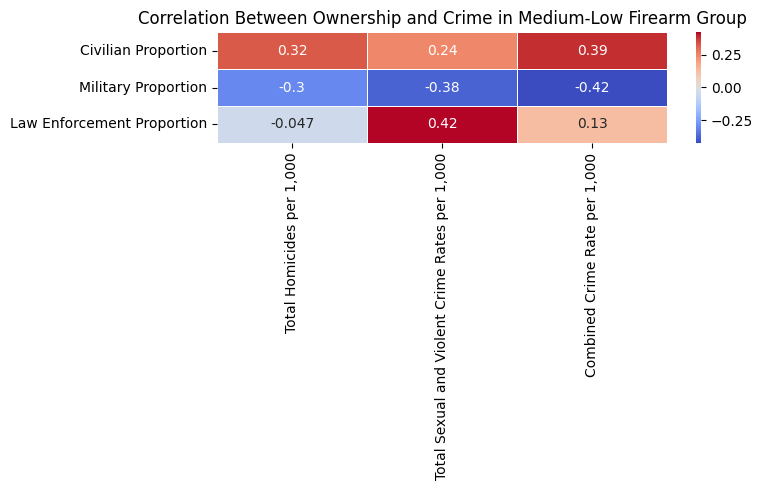

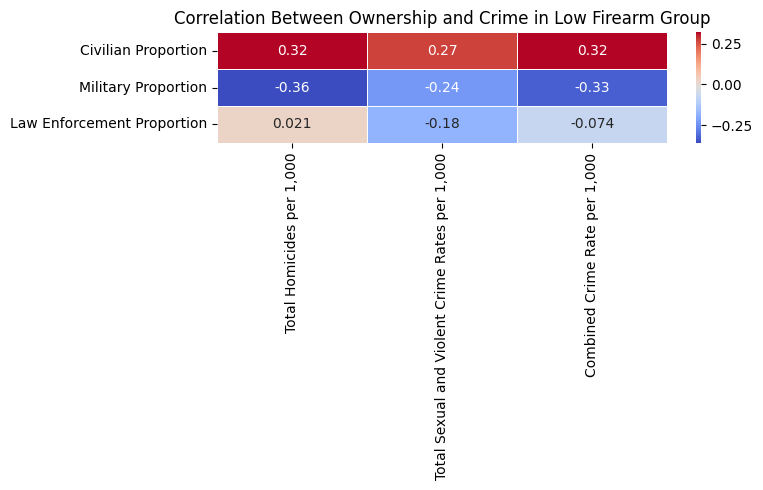

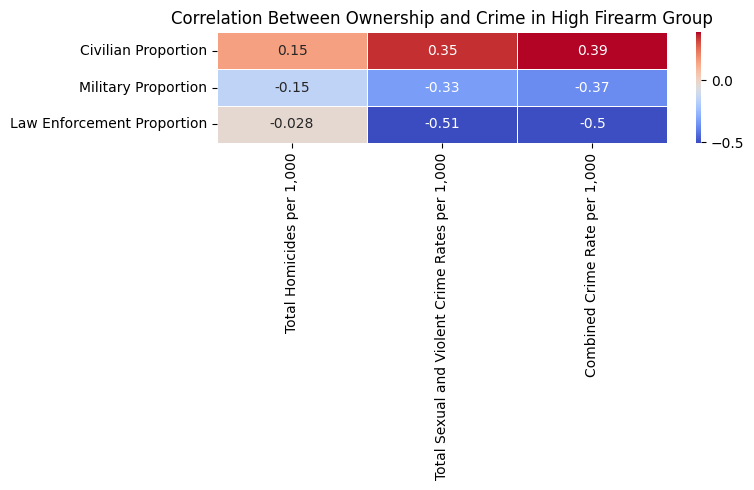

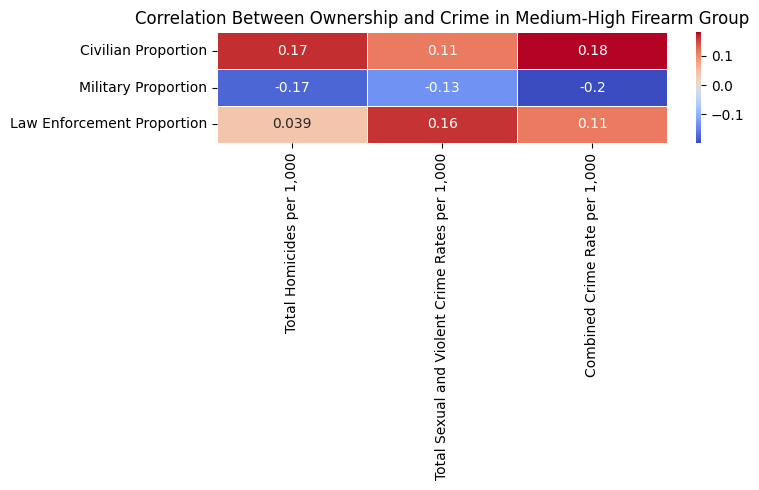

In [85]:
within_group_correlation_dict = {}

for group in data["Total Firearms Group"].unique():
    subset = data[data["Total Firearms Group"] == group]  # Filter data per group
    
    # Compute correlation matrix
    correlation_matrix = subset[["Civilian Proportion", "Military Proportion", "Law Enforcement Proportion",
                                 "Total Homicides per 1,000", 
                                 "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]].corr()

    # Extract only ownership vs. crime correlations
    ownership_crime_correlation = correlation_matrix.loc[
        ["Civilian Proportion", "Military Proportion", "Law Enforcement Proportion"], 
        ["Total Homicides per 1,000",
         "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
    ]
    
    within_group_correlation_dict[group] = ownership_crime_correlation

    # heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(ownership_crime_correlation, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title(f"Correlation Between Ownership and Crime in {group} Firearm Group")
    plt.xticks(rotation=90)
    plt.yticks(rotation=00)
    plt.tight_layout()
    plt.show()

## **Below is the statistical testing. I used Negative Binomial Regression. I have put ChatGPT-ed explanations of the regression analysis so you can get an idea what the different parts are doing. After the actual code and the results, there is another explanation that summarizes the findings, some of which show statistical significance, which is good. My main concern now is how to present the results in the report. I cannot think of many options for nice plots. Feel free to give ideas.**

### **Explanation of the Regression Analysis Below**

This analysis examines how different types of firearm ownership (civilian, law enforcement, and military) affect various crime rates, while accounting for differences across firearm groups (low, medium, high total firearms) and controlling for economic conditions (GDP). The **Negative Binomial regression model** is used to handle count-based crime data with overdispersion (variance > mean). Here's the breakdown of the key steps:

---

### **1. Interaction Terms and Variables Setup**
- **Interaction terms** are created to explore how the effect of firearm ownership changes across different **total firearm groups**:
  - **Civilian_Firearms_Interaction**: Civilian firearm ownership × firearm group code  
  - **LawEnforcement_Firearms_Interaction**: Law enforcement firearms × firearm group code  
  - **Military_Firearms_Interaction**: Military firearms × firearm group code  

These interactions allow the model to test whether countries with similar total firearm counts but **different firearm distributions** experience different crime patterns.

- The **independent variables** (`X`) include:
  - Main effects of firearm ownership types (civilian, military, law enforcement)
  - Interaction terms to capture group-specific differences
  - **GDP per 1,000** as a control variable to account for the role of economic conditions
  - A **constant term** to model baseline crime levels

---

### **2. Negative Binomial Regression for Each Crime Type**
- The model is applied to four types of crime rates as dependent variables (`y`):  
  - Total homicides per 1,000  
  - Total sexual crimes per 1,000  
  - Total violent crimes per 1,000  
  - Combined crime rate per 1,000  

For each crime type, the model estimates the relationship between firearm ownership and crime, accounting for the interaction effects of firearm groups and GDP.

---

### **3. Interpreting the Regression Output**
- **Regression results** provide the coefficients, p-values, and confidence intervals for each variable:
  - **Main effects:** Indicate whether civilian, military, or law enforcement firearms directly influence crime rates.
  - **Interaction terms:** Show whether the effect of firearm ownership changes across different firearm groups (low, medium, high).
  - **GDP:** Tests whether economic conditions independently influence crime rates.

---

### **4. Wald Test for Group Differences**
- A **Wald test** is performed for the interaction terms to check if differences between total firearm groups (low, medium, high) are statistically significant.  
- If the Wald test is significant, it suggests that the relationship between firearm ownership and crime **varies across groups**.

---

### **Purpose and Takeaways**
This analysis aims to determine:
- Whether **different types of firearm ownership** (civilian, military, law enforcement) are associated with variations in crime rates.  
- Whether **countries grouped by total firearm levels** experience varying impacts on crime due to firearm ownership distributions.
- How much of the relationship between firearms and crime is **modified by economic factors (GDP)**.  
The findings from the regression and Wald test will reveal whether group-specific or economic conditions significantly shape the firearm-crime relationship.

In [86]:
# Prepare interaction terms
data["Civilian_Firearms_Interaction"] = data["Estimate of firearms in civilian possession per 1,000"] * pd.Categorical(data["Total Firearms Group"]).codes
data["LawEnforcement_Firearms_Interaction"] = data["Total law enforcement firearms per 1,000"] * pd.Categorical(data["Total Firearms Group"]).codes
data["Military_Firearms_Interaction"] = data["Total military firearms per 1,000"] * pd.Categorical(data["Total Firearms Group"]).codes

# Independent variables with interactions and control for GDP
X = data[[
    "Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000",
    "Civilian_Firearms_Interaction",
    "LawEnforcement_Firearms_Interaction",
    "Military_Firearms_Interaction",
    "Country GDP per 1,000"
]]
X = sm.add_constant(X)

nb_results_combined = {}
crime_types = ["Total Homicides per 1,000",
               "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]

for crime in crime_types:
    y = data[crime]
    
    # Fit Negative Binomial regression with interaction terms
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    nb_results_combined[crime] = model
    
    print(f"\nCombined Negative Binomial Regression Results for {crime}:\n")
    print(model.summary())

    # Wald test for interaction terms to check if group differences are significant
    print("\nWald test for interaction terms:")
    print(model.wald_test_terms().summary_frame())


Combined Negative Binomial Regression Results for Total Homicides per 1,000:

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   77
Model:                                   GLM   Df Residuals:                       69
Model Family:               NegativeBinomial   Df Model:                            7
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -140.47
Date:                       Thu, 30 Jan 2025   Deviance:                       68.546
Time:                               19:10:00   Pearson chi2:                     91.7
No. Iterations:                           10   Pseudo R-squ. (CS):             0.4287
Covariance Type:                   nonrobust                                         
                                                            c

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning

### **Summary Table: How Firearm Ownership Types Affect Crime Rates Across Groups**

| **Dependent Variable**                                  | **Significant Predictors**                                                                                         | **Direction of Effect**                        | **Key Findings/Interpretation**                                                                                                                                                                                                                       |
|--------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------|------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Total Homicides per 1,000**                          | - **Civilian Firearms per 1,000** (**p = 0.000**)  <br> - **Civilian Firearms Interaction** (**p = 0.000**) <br> - **GDP** (**p = 0.000**) | + for civilian firearms, negative for interaction term | **More civilian firearms are associated with higher homicide rates.** However, the significant negative interaction term suggests that at very high levels of civilian firearms, the effect on homicides diminishes or reverses. Higher GDP reduces homicides. In low-firearm groups, the positive effect of civilian firearms on homicide rates is stronger. As you move to medium and high-firearm groups, this effect weakens or potentially reverses (suggested by the significant negative interaction). |
| **Total Sexual and Violent Crime Rates per 1,000**     | - **GDP** (**p = 0.000**) <br> (Marginal effects for civilian firearms: **p = 0.078**)                                                                | Positive for GDP, weak positive for civilian firearms | **GDP significantly increases sexual and violent crime rates.** Civilian firearms have a weak, borderline-positive effect, but this is not fully significant. In low-firearm groups, there’s a slight increase in sexual/violent crimes as civilian firearms increase.As you move to higher firearm groups, the effect weakens or levels off.                                                                                           |
| **Combined Crime Rate per 1,000**                      | - **Civilian Firearms per 1,000** (**p = 0.001**)  <br> - **Civilian Firearms Interaction** (**p = 0.001**)                                           | + for civilian firearms, negative for interaction term | **More civilian firearms are associated with higher combined crime rates.** The interaction term indicates that this effect diminishes at high levels of civilian firearms. No significant effect for law enforcement or military firearms. In low-firearm groups, increasing civilian firearms significantly increases combined crime rates. As you move to higher firearm groups, this effect flattens out or diminishes.              |

---

### **Key Points:**
1. **Civilian Firearms Are the Only Significant Predictor of Crime Rates (Except GDP):**  
   - For **homicides and combined crime rates**, **more civilian firearms are associated with increased crime.**
   - **Law enforcement and military firearms do not have significant effects** on any crime types across any group - meaning that the effect is not significant in any of the groups.

2. **Non-Linear Effect of Civilian Firearms:**  
   - The **interaction term for civilian firearms is significant and negative**, suggesting a **non-linear relationship**:  
     - At **low to moderate levels of civilian firearms**, crime rates increase, but the effect **diminishes or reverses** at very high levels.

3. **GDP Is a Major Factor for Sexual and Violent Crimes:**  
   - **Higher GDP significantly increases sexual and violent crime rates.**  
   - This may reflect **better crime reporting in wealthier countries.**

4. **No Evidence That Law Enforcement or Military Firearms Affect Crime:**  
   - Neither law enforcement nor military firearm ownership significantly influences homicides, sexual/violent crimes, or combined crime rates.

---

### **What Do These Results Mean?**
- **Civilian firearm ownership is the key driver of crime rates, particularly for homicides and overall crime.**  
- However, **its effect is non-linear**, meaning that **increasing civilian firearms initially raises crime, but the effect diminishes or reverses at very high levels.**
- **GDP’s influence is most significant for sexual and violent crimes.** Wealthier countries likely have higher reporting rates or social factors that contribute to this.

### **Visualizations for Q2 (Needs attention).**

### More visualizations possibly needed. **Feel free to think what could be useful and add it!**

/var/folders/07/1h78q6dd1jv28c8bsv9ztx140000gn/T/ipykernel_93317/37151937.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Total Firearms Group", y=i, palette="coolwarm")


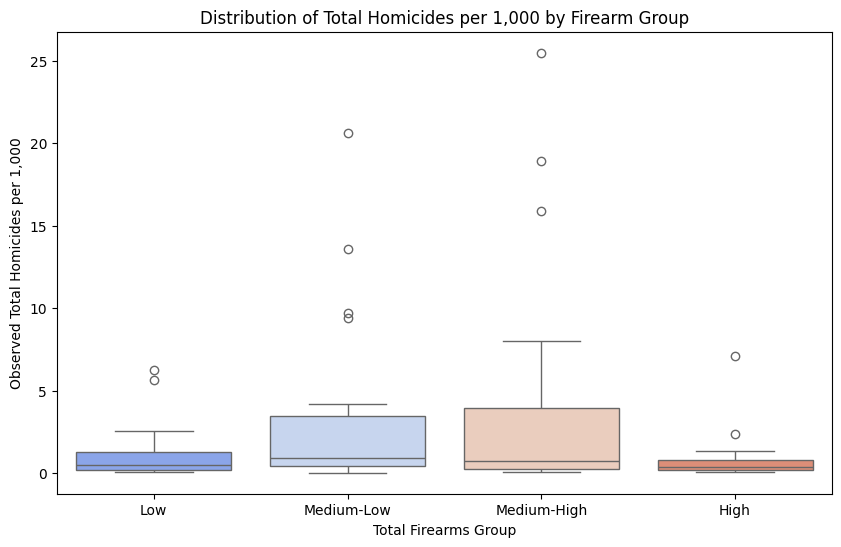

/var/folders/07/1h78q6dd1jv28c8bsv9ztx140000gn/T/ipykernel_93317/37151937.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Total Firearms Group", y=i, palette="coolwarm")


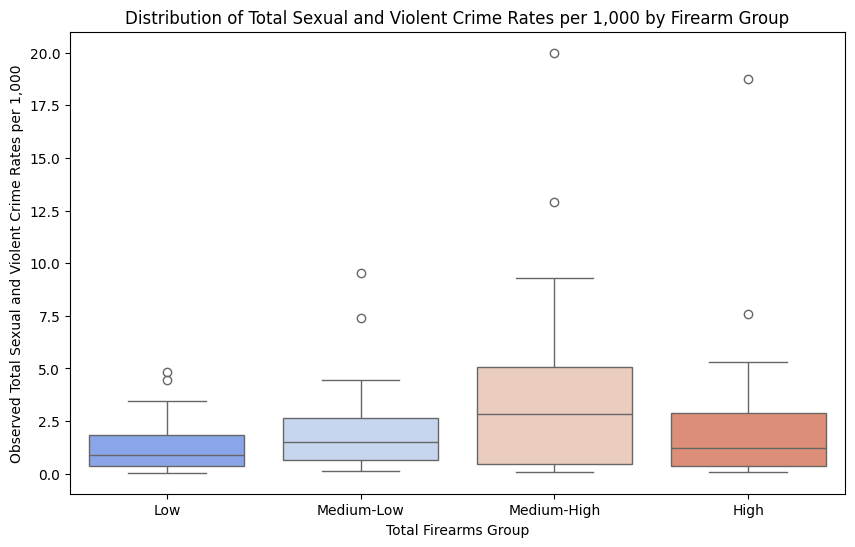

In [87]:
lst = ["Total Homicides per 1,000", "Total Sexual and Violent Crime Rates per 1,000"]

for i in lst: 
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x="Total Firearms Group", y=i, palette="coolwarm")
    plt.title(f"Distribution of {i} by Firearm Group")
    plt.xlabel("Total Firearms Group")
    plt.ylabel(f"Observed {i}")
    plt.show()

Not sure if useful

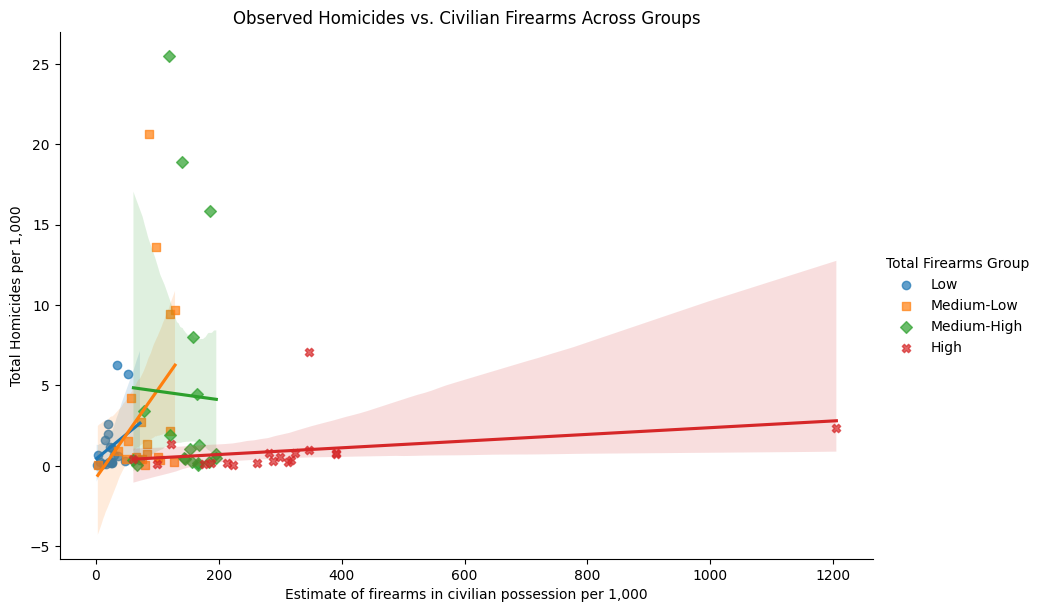

In [88]:
sns.lmplot(data=data, x="Estimate of firearms in civilian possession per 1,000", 
           y="Total Homicides per 1,000", hue="Total Firearms Group", 
           height=6, aspect=1.5, markers=["o", "s", "D", "X"], scatter_kws={'alpha':0.7})
plt.title("Observed Homicides vs. Civilian Firearms Across Groups")
plt.show()

# **Question 3. Check if GDP is a confounding variable**

Correlations between GDP and weapon types:
{'Estimate of firearms in civilian possession per 1,000': 0.3903721155543252, 'Total law enforcement firearms per 1,000': -0.1987490421888613, 'Total military firearms per 1,000': -0.012880103268226337}


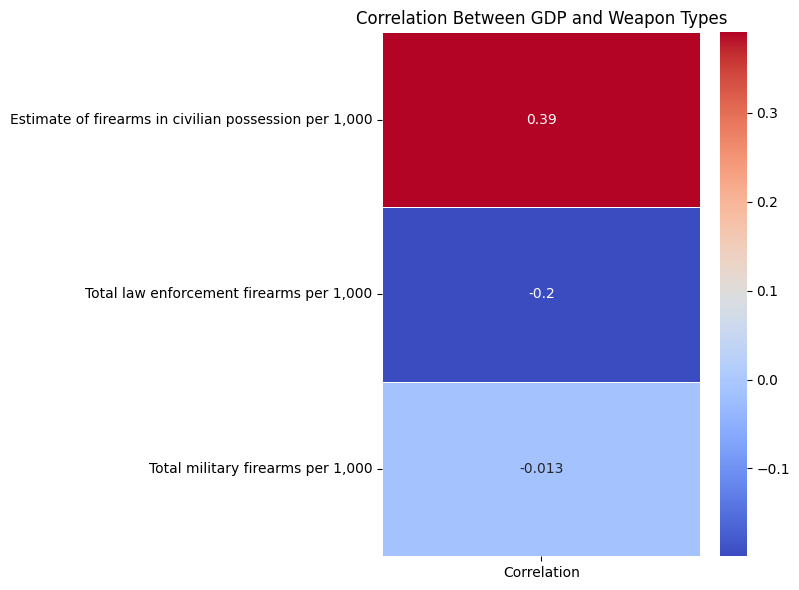

In [89]:
# GDP as a Confounding Variable
gdp_column = "Country GDP per 1,000"

# Correlations between GDP and crime stats
gdp_crime_correlations = {}
for crime in ["Estimate of firearms in civilian possession per 1,000", "Total law enforcement firearms per 1,000", "Total military firearms per 1,000"]:
    correlation, _ = pearsonr(data[gdp_column], data[crime])
    gdp_crime_correlations[crime] = correlation

print("Correlations between GDP and weapon types:")
print(gdp_crime_correlations)

# Create heatmap
correlation_df = pd.DataFrame.from_dict(gdp_crime_correlations, orient='index', columns=['Correlation'])
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation Between GDP and Weapon Types")
plt.tight_layout()
plt.show()

**Strong Positive Correlation – Wealthier countries have more civilian-owned firearms.**

Correlations between GDP and crime types:
{'Total Homicides per 1,000': -0.20059830123353528, 'Total Sexual and Violent Crime Rates per 1,000': 0.4052619463070541, 'Combined Crime Rate per 1,000': 0.07676359957457547}


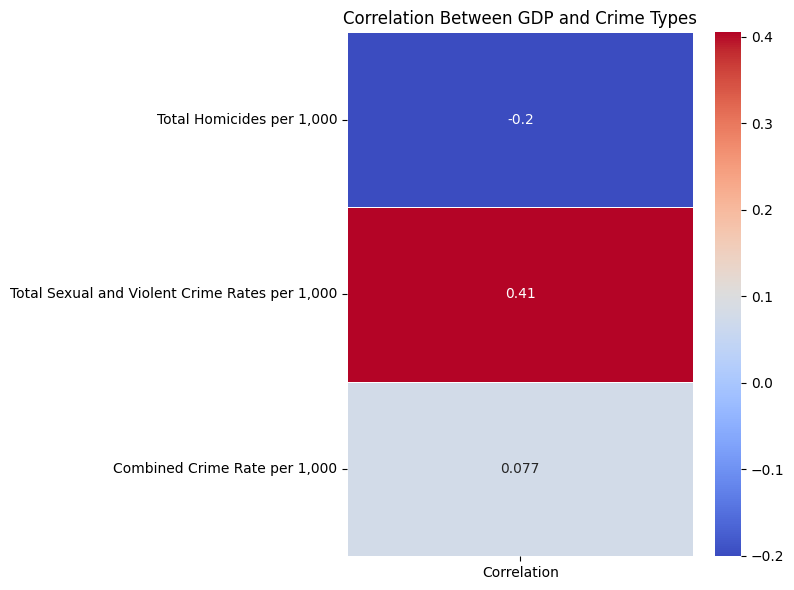

In [90]:
# GDP as a Confounding Variable
gdp_column = "Country GDP per 1,000"

# Correlations between GDP and crime stats
gdp_crime_correlations = {}
for crime in crime_columns:
    correlation, _ = pearsonr(data[gdp_column], data[crime])
    gdp_crime_correlations[crime] = correlation

print("Correlations between GDP and crime types:")
print(gdp_crime_correlations)

# Create heatmap
correlation_df = pd.DataFrame.from_dict(gdp_crime_correlations, orient='index', columns=['Correlation'])
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation Between GDP and Crime Types")
plt.tight_layout()
plt.show()

### **Final Answer: Is GDP a Confounder?**  
1. **GDP strongly correlates with civilian firearm ownership** (**0.39**), meaning wealthier countries tend to have more civilian firearms.  
2. **GDP significantly correlates with certain crime types**:
   - **Negative correlation with homicides (-0.2)** → Higher GDP countries have fewer homicides.
   - **Positive correlation with sexual crimes (0.56) and violent crimes (0.32)** → Wealthier countries report more of these crimes.


### **I include GDP in the regressions above so it should be taken care of**

##  **Question 4. Idk if we should drop this question about the ratio of government vs civilian owned and the crime rates. Seems repetitive and I don't feel like doing all of the statistical stuff and plotting once again. We can try and answer this question with the things we already have.**

**Create the ratio between the two and run regression to see if the effect is significant**

In [91]:
# Create the government-to-civilian ratio variable
data["Gov_to_Civilian_Ratio"] = (data["Total law enforcement firearms per 1,000"] + data["Total military firearms per 1,000"]) / data["Estimate of firearms in civilian possession per 1,000"]

gov_ratio_results = {}
crime_types = ["Total Homicides per 1,000",
               "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]

# Define and fit the model for each crime type
for crime in crime_types:
    X = data[[
        "Gov_to_Civilian_Ratio",
        "Country GDP per 1,000"  # Control for economic conditions
    ]]
    
    X = sm.add_constant(X)  
    y = data[crime]  # Dependent variable: crime rate
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    gov_ratio_results[crime] = model.summary()  
    
    print(f"\nNegative Binomial Regression Results for {crime} (Gov-to-Civilian Ratio Analysis):\n")
    print(model.summary())


Negative Binomial Regression Results for Total Homicides per 1,000 (Gov-to-Civilian Ratio Analysis):

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   77
Model:                                   GLM   Df Residuals:                       74
Model Family:               NegativeBinomial   Df Model:                            2
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -148.50
Date:                       Thu, 30 Jan 2025   Deviance:                       84.593
Time:                               19:10:01   Pearson chi2:                 2.34e+10
No. Iterations:                           11   Pseudo R-squ. (CS):             0.2963
Covariance Type:                   nonrobust                                         
                            coef    s

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### **Summary Table: Gov-to-Civilian Ratio and Its Effect on Crime**

| **Dependent Variable**                                  | **Significant Predictors**                        | **Direction of Effect**                     | **Key Findings/Interpretation**                                                                                                                                                  |
|--------------------------------------------------------|--------------------------------------------------|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Total Homicides per 1,000**                          | - **Gov-to-Civilian Ratio** (**p = 0.001**)  <br> - **GDP** (**p = 0.000**) | Negative for ratio, negative for GDP       | **Higher Gov-to-Civilian ratios are associated with significantly lower homicide rates.** Higher GDP is also linked to reduced homicides, suggesting strong protective effects. |
| **Total Sexual and Violent Crime Rates per 1,000**     | - **GDP** (**p = 0.000**)                         | Positive for GDP, weak negative for ratio  | **Gov-to-Civilian ratio has a weak, non-significant negative effect (p = 0.122).** Higher GDP significantly increases sexual and violent crime rates, likely due to reporting factors. |
| **Combined Crime Rate per 1,000**                      | - **Gov-to-Civilian Ratio** (marginal, **p = 0.058**) | Weak negative effect                      | **A higher Gov-to-Civilian ratio weakly reduces combined crime rates (near significance).** The effect of GDP on combined crime rates is not statistically significant.          |

---

### **Key Points:**

1. **Gov-to-Civilian Ratio Reduces Homicides:**  
   - A **higher proportion of government-held weapons relative to civilian firearms** is **significantly associated with lower homicide rates (p = 0.001).**
   - **This supports the idea that higher government firearm control (via law enforcement/military) reduces violent outcomes like homicides.**

2. **Weak to Non-Significant Effect on Sexual and Violent Crimes:**  
   - For sexual and violent crimes, the effect of the Gov-to-Civilian ratio is **weak and not statistically significant** (p = 0.122).  
   - **This suggests that sexual and violent crimes may be driven more by other factors (e.g., social or economic conditions).**

3. **Weak Negative Effect on Combined Crime Rate (Marginal Significance):**  
   - A **higher Gov-to-Civilian ratio is weakly associated with lower overall crime rates (p = 0.058).**  
   - The marginal significance suggests the **protective effect may not apply uniformly across all crime types.**

4. **GDP Strongly Influences Crime:**  
   - **GDP significantly reduces homicides (p = 0.000) but increases sexual and violent crime rates (p = 0.000).**  
   - **Wealthier countries likely have better reporting mechanisms for sexual and violent crimes.**

---

### **Interpretation of the Results:**
- **Homicides:** Higher government control of firearms is clearly beneficial for reducing homicide rates, likely due to the **deterrence effect of law enforcement or restrictions on civilian access.**
- **Sexual and Violent Crimes:** The weak effect of the Gov-to-Civilian ratio suggests that these crimes are **less directly affected by firearm distribution.**
- **Combined Crime Rates:** The marginally significant effect points to **potential protective effects of government-held firearms** but suggests the impact on overall crime is limited.


/var/folders/07/1h78q6dd1jv28c8bsv9ztx140000gn/T/ipykernel_93317/737044437.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="GDP per 1,000", bbox_to_anchor=(1.05, 1), loc='upper left')


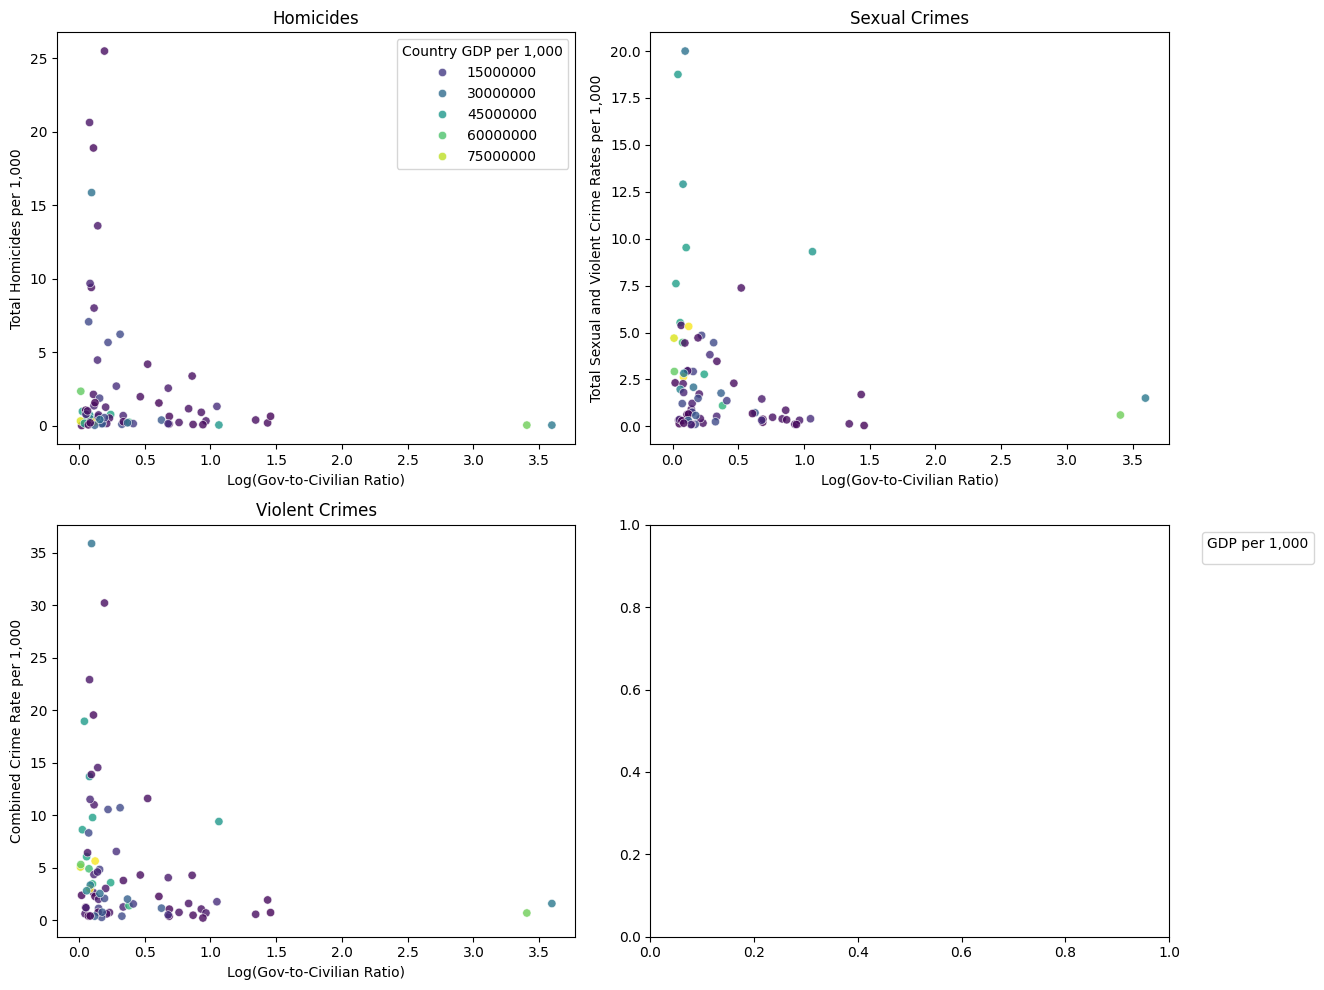

In [92]:
# Apply log transformation to the Gov-to-Civilian Ratio
data["Log_Gov_to_Civilian_Ratio"] = np.log1p(data["Gov_to_Civilian_Ratio"])  # log(1 + x) to handle zeros

# Define crime types and titles for subplots
crime_types = ["Total Homicides per 1,000",
               "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
titles = ["Homicides", "Sexual Crimes", "Violent Crimes", "Combined Crime Rate"]

# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Generate scatterplots for each crime type, colored by GDP
for i, crime in enumerate(crime_types):
    sns.scatterplot(
        x=data["Log_Gov_to_Civilian_Ratio"], 
        y=data[crime], 
        hue=data["Country GDP per 1,000"], 
        palette='viridis', 
        ax=axes[i], 
        alpha=0.8, 
        legend=(i == 0)  # Show legend only for the first subplot
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Log(Gov-to-Civilian Ratio)")
    axes[i].set_ylabel(crime)

# Adjust layout and add legend for the first plot
plt.tight_layout()
plt.legend(title="GDP per 1,000", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


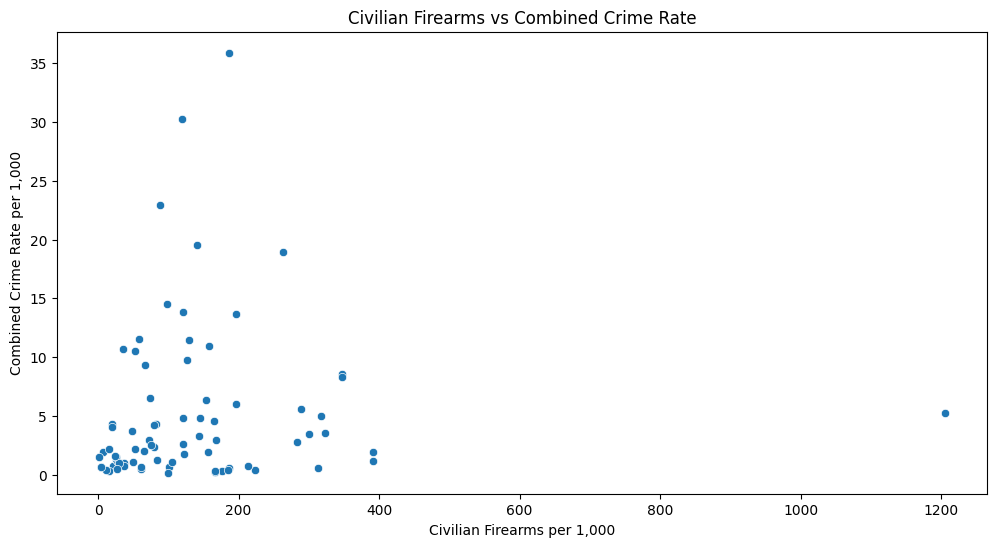

Correlation between civilian firearms and combined crime rate: 0.08837318092299785


In [93]:
# Impact of Civilian Gun Ownership
# Relationship between civilian firearms per 1,000 and crime rates
civ_gun_column = "Estimate of firearms in civilian possession per 1,000"

plt.figure(figsize=(12, 6))
sns.scatterplot(x=civ_gun_column, y='Combined Crime Rate per 1,000', data=data)
plt.title('Civilian Firearms vs Combined Crime Rate')
plt.xlabel('Civilian Firearms per 1,000')
plt.ylabel('Combined Crime Rate per 1,000')
plt.show()

# Correlation
civ_gun_correlation, _ = pearsonr(data[civ_gun_column], data['Combined Crime Rate per 1,000'])
print(f"Correlation between civilian firearms and combined crime rate: {civ_gun_correlation}")